# Project 2 - Ames Housing Data and Housing Price Predictions

## 1. Problem:
Create a housing price model that will predict housing sale prices based on the features in the Ames Housing Dataset.

The data description can be found at : http://jse.amstat.org/v19n3/decock/DataDocumentation.txt.

## 2. Executive Summary

The data was imported via pandas, and checked for null values. Minor cleanup was attempted. Several new interaction features were generated. A basic OLS regression was performed on intact, "continuous" numeric columns. Correlations were generated, and the most promising coefficients were selected. From there, a basic model was generated from only the intact numeric columns. Columns with small amounts of NaN values were imputes with the column average.

At this point, a polynomial expansion of the numeric features was generated and tested via a LASSO optimization. The LASSO model generated lower variance in the predictions, and the non-zero coefficients were noted and used on the next iteration of the model.

Dummy features were then explored, starting with the ones showing the highest correlation. Iteratively adding these yielded a final R2 score of approximately 0.900 for both training and test data. The predictions for the Kaggle test were then uploaded.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import missingno as msno
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

r_state=24

pd.set_option('max_columns', 100, "max_rows", 100)
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_raw = pd.read_csv('./datasets/train.csv')
df = df_raw
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
# Let's grab the kaggle data as well

kaggle_raw = pd.read_csv('./datasets/test.csv')
kg = kaggle_raw
kg.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


## 3. Exploratory Data Analysis
Here we will take a look at the data, and build a basic model from features that don't require much manipulation.

First, let's get a good representation of nulls. Then we'll make some decisions on whether to drop or impute values.

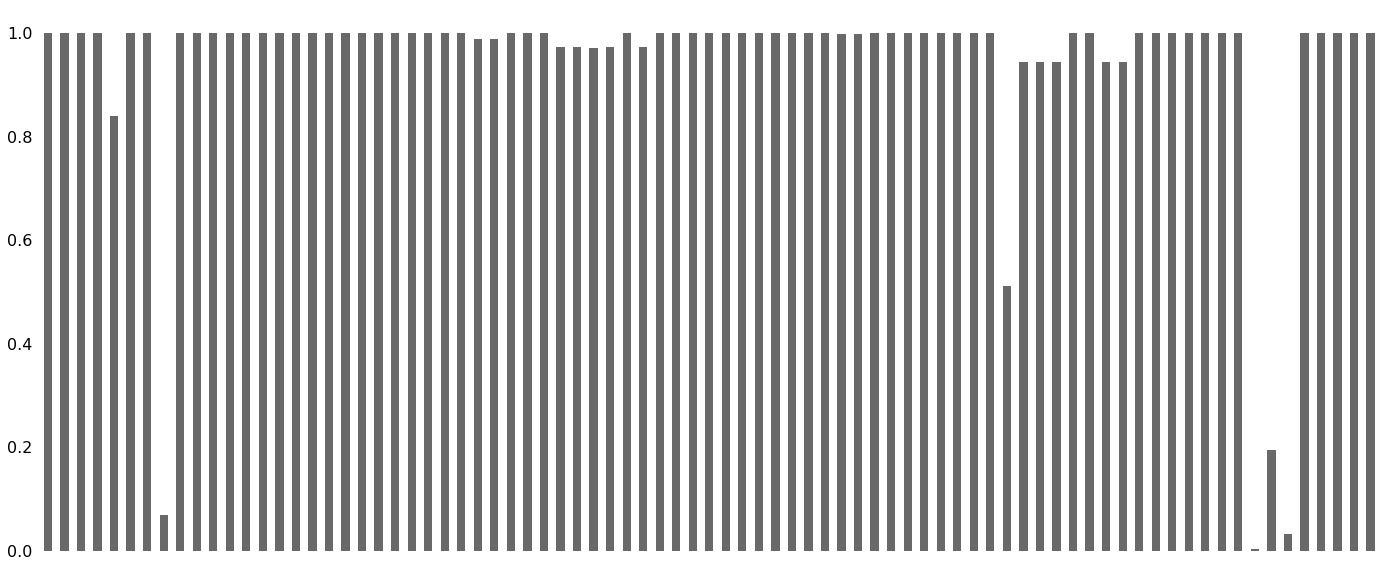

In [4]:
msno.bar(df)


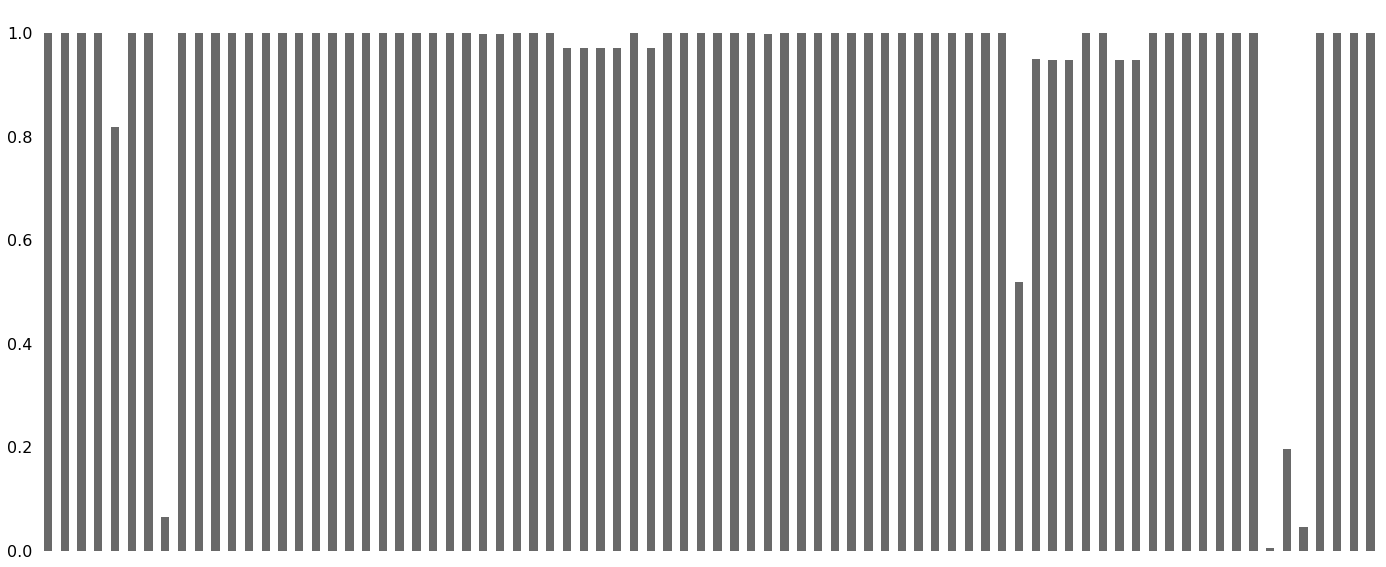

In [5]:
msno.bar(kg)

In [6]:
# looks like we are missing a lot of data
# lets get a look at what that missing data is:

df.isnull().sum()

Id                    0
PID                   0
MS SubClass           0
MS Zoning             0
Lot Frontage        330
Lot Area              0
Street                0
Alley              1911
Lot Shape             0
Land Contour          0
Utilities             0
Lot Config            0
Land Slope            0
Neighborhood          0
Condition 1           0
Condition 2           0
Bldg Type             0
House Style           0
Overall Qual          0
Overall Cond          0
Year Built            0
Year Remod/Add        0
Roof Style            0
Roof Matl             0
Exterior 1st          0
Exterior 2nd          0
Mas Vnr Type         22
Mas Vnr Area         22
Exter Qual            0
Exter Cond            0
Foundation            0
Bsmt Qual            55
Bsmt Cond            55
Bsmt Exposure        58
BsmtFin Type 1       55
BsmtFin SF 1          1
BsmtFin Type 2       56
BsmtFin SF 2          1
Bsmt Unf SF           1
Total Bsmt SF         1
Heating               0
Heating QC      

In [7]:
kg.isnull().sum()

Id                   0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       160
Lot Area             0
Street               0
Alley              820
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type         1
Mas Vnr Area         1
Exter Qual           0
Exter Cond           0
Foundation           0
Bsmt Qual           25
Bsmt Cond           25
Bsmt Exposure       25
BsmtFin Type 1      25
BsmtFin SF 1         0
BsmtFin Type 2      25
BsmtFin SF 2         0
Bsmt Unf SF          0
Total Bsmt SF        0
Heating              0
Heating QC           0
Central Air          0
Electrical 

In [8]:
# lets describe the numeric data:
df.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [9]:
# ID and PID are worthless to us:
df = df.drop(columns=['Id', 'PID'])
kg = kg.drop(columns=['Id', 'PID'])

In [10]:
# lets impute bsmt fin sf NaNs with mean values 
df = df.replace({'BsmtFin SF 1' : np.nan}, df['BsmtFin SF 1'].mean())
df = df.replace({'BsmtFin SF 2' : np.nan}, df['BsmtFin SF 2'].mean())
df = df.replace({'Total Bsmt SF' : np.nan}, df['Total Bsmt SF'].mean())
kg = kg.replace({'BsmtFin SF 1' : np.nan}, df['BsmtFin SF 1'].mean())
kg = kg.replace({'BsmtFin SF 2' : np.nan}, df['BsmtFin SF 2'].mean())
kg = kg.replace({'Total Bsmt SF' : np.nan}, df['Total Bsmt SF'].mean())

In [11]:
# do the same for ms vnr area
df = df.replace({'Mas Vnr Area' : np.nan}, df['Mas Vnr Area'].mean())
kg = kg.replace({'Mas Vnr Area' : np.nan}, df['Mas Vnr Area'].mean())

In [12]:
# Lets make an engineered feature called sf_room that is:
df['sf_room'] = df['Gr Liv Area'] * df['TotRms AbvGrd']
df['sf_broom'] = df['Gr Liv Area'] * df['Bedroom AbvGr']
kg['sf_room'] = kg['Gr Liv Area'] * kg['TotRms AbvGrd']
kg['sf_broom'] = kg['Gr Liv Area'] * kg['Bedroom AbvGr']

# And maybe one for garage / cars:
df["sf_car"] = df['Garage Area'] * df['Garage Cars']
kg["sf_car"] = kg['Garage Area'] * kg['Garage Cars']

# And maybe some for qual and cond:
df['sf_qual'] = df['Gr Liv Area'] * df['Overall Qual']
df['sf_cond'] = df['Gr Liv Area'] * df['Overall Cond']
df['rm_qual'] = df['TotRms AbvGrd'] * df['Overall Qual']
df['rm_cond'] = df['TotRms AbvGrd'] * df['Overall Cond']
df['bs_qual'] = df['Total Bsmt SF'] * df['Overall Qual']
df['bsf_qual'] = df['BsmtFin SF 1'] * df['Overall Qual']
df['lt_qual'] = df['Lot Area'] * df['Overall Qual']
df['wd_qual'] = df['Wood Deck SF'] * df['Overall Qual']
df['pr_qual'] = df['Open Porch SF'] * df['Overall Qual']
kg['sf_qual'] = kg['Gr Liv Area'] * kg['Overall Qual']
kg['sf_cond'] = kg['Gr Liv Area'] * kg['Overall Cond']
kg['rm_qual'] = kg['TotRms AbvGrd'] * kg['Overall Qual']
kg['rm_cond'] = kg['TotRms AbvGrd'] * kg['Overall Cond']
kg['bs_qual'] = kg['Total Bsmt SF'] * kg['Overall Qual']
kg['bsf_qual'] = kg['BsmtFin SF 1'] * kg['Overall Qual']
kg['lt_qual'] = kg['Lot Area'] * kg['Overall Qual']
kg['wd_qual'] = kg['Wood Deck SF'] * kg['Overall Qual']
kg['pr_qual'] = kg['Open Porch SF'] * kg['Overall Qual']

# and finally maybe one more for year remod and qual:
df['yr_qual'] = df['Year Remod/Add'] * df['Overall Qual']
df['yr_cond'] = df['Year Remod/Add'] * df['Overall Cond']
kg['yr_qual'] = kg['Year Remod/Add'] * kg['Overall Qual']
kg['yr_cond'] = kg['Year Remod/Add'] * kg['Overall Cond']

In [13]:
# it's to be expected that there are going to be some low outliers, 
# and we are missing the column "Sale Condition" that would help us
# account for some of these. So lets just drop the 3 lowest priced homes
# in the dataset

low_drop = list(df.nsmallest(3, 'SalePrice').index)
df.drop(index=low_drop, inplace=True)
df.index = list(range(len(df)))
df.describe()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,sf_room,sf_broom,sf_car,sf_qual,sf_cond,rm_qual,rm_cond,bs_qual,bsf_qual,lt_qual,wd_qual,pr_qual,yr_qual,yr_cond
count,2048.000000,1718.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2047.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2046.000000,2046.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,1935.000000,2047.000000,2047.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2047.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,57.053223,69.054715,10064.269043,6.117676,5.564453,1971.767578,1984.229492,99.841948,442.706690,48.029277,568.119199,1058.854975,1165.078125,329.811523,5.520996,1500.410645,0.428152,0.063539,1.578125,0.371582,2.844727,1.042969,6.438965,0.591309,1978.747804,1.777235,473.746947,93.971191,47.371094,22.548828,2.595215,16.535645,2.401367,51.649902,6.219727,2007.773926,181705.844238,10294.461426,4477.525391,989.112848,9579.854492,8286.624512,40.230957,35.664062,6825.776832,2889.789161,62596.810059,621.545898,319.509766,12156.287109,11042.100098
std,42.839444,23.278427,6746.509455,1.419152,1.102356,30.155948,21.023681,174.107354,461.220565,165.071263,445.032606,448.880160,396.432443,425.795971,51.105842,500.012762,0.522800,0.251878,0.549237,0.501208,0.826592,0.209937,1.559184,0.638653,25.420832,0.764057,215.732444,128.593343,65.947337,59.849931,25.247901,57.412746,37.810135,573.810601,2.743124,1.311765,79074.916716,6110.431630,2552.946842,739.464039,4944.656520,3117.847187,16.192536,10.636161,4193.870687,3589.898048,48314.363831,883.174382,463.720895,2894.634445,2193.648761
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35000.000000,668.000000,0.000000,0.000000,334.000000,904.000000,2.000000,4.000000,0.000000,0.000000,5000.000000,0.000000,0.000000,1950.000000,1950.000000
25%,20.000000,58.000000,7500.000000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.750000,880.000000,0.000000,0.000000,1131.750000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129900.000000,6249.000000,2736.000000,321.000000,5926.500000,6318.000000,30.000000,30.000000,4320.000000,0.000000,38988.750000,0.000000,0.000000,9860.000000,9960.000000
50%,50.000000,68.000000,9417.500000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.500000,0.000000,475.000000,996.000000,1093.000000,0.000000,0.000000,1445.500000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162700.000000,8964.000000,4032.000000,960.000000,8690.500000,7825.000000,36.000000,35.000000,5708.000000,2046.000000,54132.000000,0.000000,163.500000,11916.000000,10030.000000
75%,70.000000,80.000000,11512.750000,7.000000,6.000000,2001.000000,2004.000000,160.000000,734.000000,0.000000,811.000000,1319.000000,1405.000000,694.250000,0.0000

In [14]:
# there is one record that is lacking numeric data for several features:
df[df['Total Bsmt SF'].isnull()]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,sf_room,sf_broom,sf_car,sf_qual,sf_cond,rm_qual,rm_cond,bs_qual,bsf_qual,lt_qual,wd_qual,pr_qual,yr_qual,yr_cond


In [15]:
# lets just get rid of it:
df.drop(index=1325, inplace=True)

In [16]:
# there's one lacking data for Garage Area:
df[df['Garage Area'].isnull()]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,sf_room,sf_broom,sf_car,sf_qual,sf_cond,rm_qual,rm_cond,bs_qual,bsf_qual,lt_qual,wd_qual,pr_qual,yr_qual,yr_cond
1709,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,150909,10968,5484,NaN,9140,10968,30,36,4295.0,2740.0,45300,870,0,9995,11994


In [17]:
# it claims there is a garage, but there is no other data for it. Let's just drop this one too
df.drop(index=1709, inplace=True)

In [18]:
# now we should re-index:
df.index = list(range(len(df)))

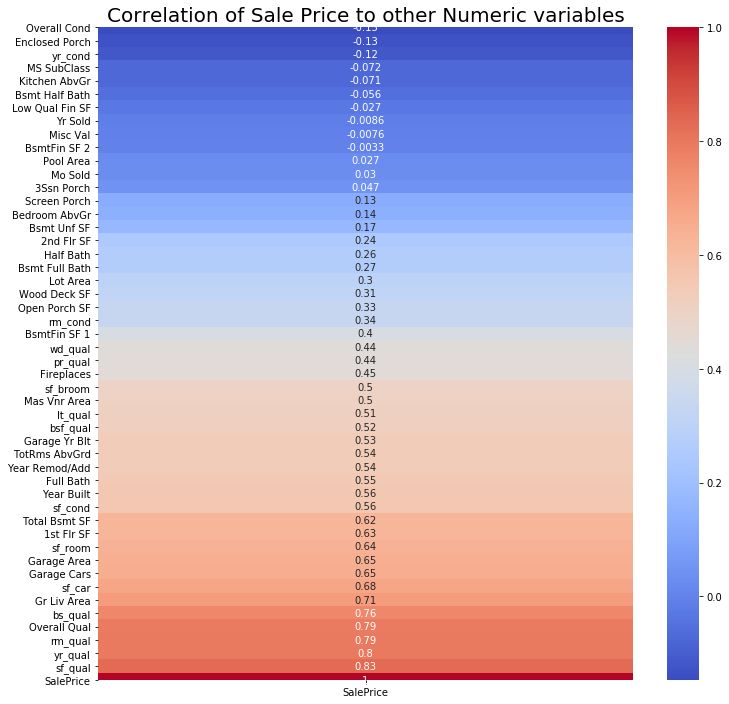

In [19]:
# Time to do a correlation heatmap!

big_na_cols = ['Lot Frontage', 'Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']
df_corr = df.drop(columns=(big_na_cols))
df_corr.dropna(axis=0, inplace=True)

plt.figure(figsize = (12, 12))
plt.title('Correlation of Sale Price to other Numeric variables', fontsize=20)
sns.heatmap(df_corr.corr()[['SalePrice']].sort_values('SalePrice'), annot=True, cmap='coolwarm')

In [20]:
# Time to do a correlation heatmap!
# First, lets select the interesting continuousish columns:
feat_list = [
    'sf_qual',
    'yr_qual',
    'rm_qual',
    'Gr Liv Area',
    'sf_car',
    'Garage Area',
    'sf_room',
    '1st Flr SF',
    'Total Bsmt SF',
    'sf_cond',
    'bs_qual',
    'Mas Vnr Area',
    'sf_broom',
    'bsf_qual',
    'BsmtFin SF 1',
    'rm_cond',
    'Open Porch SF',
    'Wood Deck SF',
    'lt_qual',
    'pr_qual',
    'wd_qual'
]

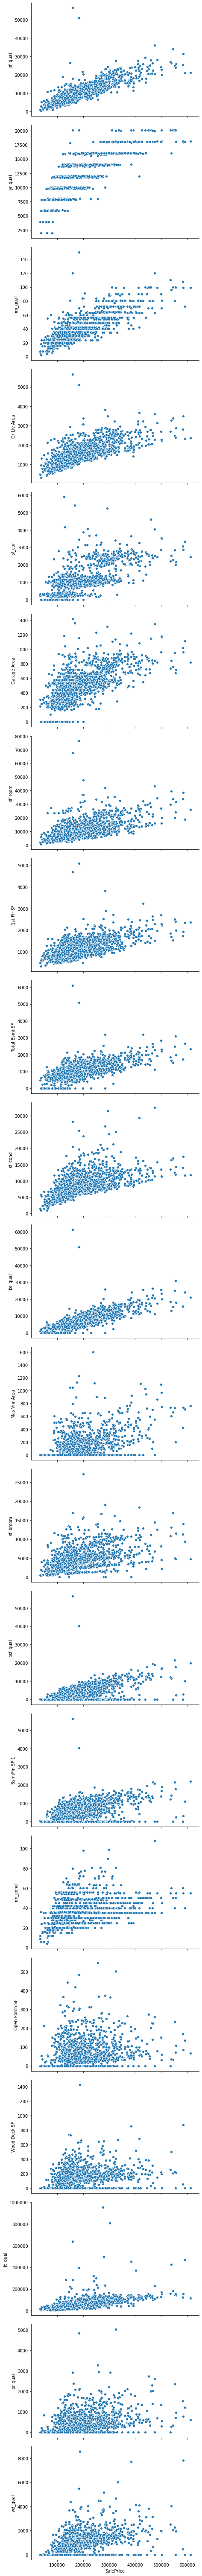

In [21]:
# Lets take a look at the relationship between our continuous features and price

sns.pairplot(df, x_vars='SalePrice', y_vars=feat_list, height=4, aspect=1.6);

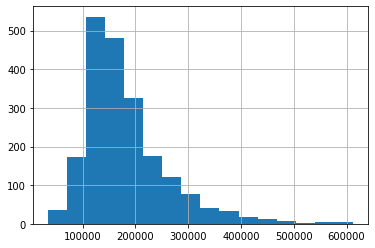

In [22]:
# got a couple of weird outliers, but we'll leave them in for now.
# lets look at sale price histograms:
df['SalePrice'].hist(bins=16)

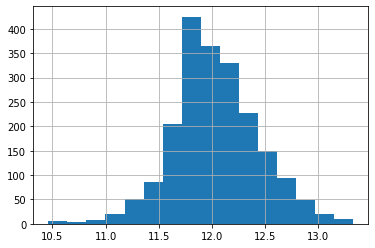

In [23]:
np.log(df['SalePrice']).hist(bins=16)

In [24]:
# looks like we will definitely be using the ln of sale price:
df['ln_price'] = np.log(df['SalePrice'])

### EDA findings:
Most of the null values are categorical that are associated with other features, eg Bsmt Qual is probably only populated when a house actually has a basement. This will be further confirmed as we dig more into feature selection.

Fortunately, it looks like most of the columns that are missing values are categorical in nature. This means that if we choose to use them as dummys, the NaNs will be ignored. We'll dig a little deeper on some of the others like Lot Frontage later. It may be the case that lot frontage is a NaN for categories like appartments and condos, in which case we can impute a proxy like the mean for all of those since the difference can be accounted for in another variable. Another option is imputing them with 0's and using an engineered feature like Lot Frontage * SubClassDummy.

## 4. Initial Modeling

We'll start with a model that only incorporates the numerical features that we have selected above and submit to Kaggle to see how we do relative to the rest of the cohorts. Because this data set has so many features, we'll do our subsequent EDA a little more piecemeal as we refine the model.

In [25]:
submission = kaggle_raw[['Id']].copy()
submission.head()

,Id
0,2658
1,2718
2,2414
3,1989
4,625


In [26]:
X_kag_test = kg[feat_list]
X_train = df[feat_list]
y_train = df['ln_price']

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
submission['SalePrice'] = np.exp(lr.predict(X_kag_test))
submission.head()

,Id,SalePrice
0,2658,171733.425271
1,2718,153901.447138
2,2414,188056.977627
3,1989,113309.614398
4,625,174211.538160


In [29]:
submission.to_csv('./submissions/submission_v0).csv', index=False)

## 5. Model Refinement

### Automation

Lets start by automating some of the more repetive code that may come up. 

In [30]:
def fit_linear_reg(X, y):
    '''Fit a linear regression model to an already defined X and y
    
    Keyword Arguments:
    X -- the feature matrix 
    y -- the target values of the feature matrix
    
    Returns:
    model -- a linear regression model fit to X and y
    predicts -- the predictions of y based on X
    resids -- the y residuals'''
     
    model = LinearRegression()
    model.fit(X, y)
    predicts = model.predict(X)
    resids = y - predicts
    
    return model, predicts, resids

In [31]:
# Let's plot resids as a function as well:

def plot_resids(y, predictions, residuals, title):
    """Plots residuals vs Observations. Requires Seaborn as sns
    
    Keyword arguments:
    y - the dependent variable training data/observed data
    predictions -- The output of a model
    residuals -- The matched residuals of the above output
    
    Returns:
    Two scatterplots: predictions vs actual values and residual vs actual values
    """
    
    fig, (ax1, ax2) = plt.subplots(figsize = (14, 6), ncols=2)
    plt.subplots_adjust(wspace = 0.25)
    fig.suptitle(title, fontsize=18)
    
    sns.scatterplot(predictions, y, ax=ax1)
    ax1.set_title("Predictions vs. Actual")
    ax1.set_ylabel("Actual")
    ax1.set_xlabel("Predicted")

    sns.scatterplot(y, residuals, ax=ax2)
    ax2.set_title('Residuals vs Observations')
    ax2.set_ylabel("Residual")
    ax2.set_xlabel("Observation")

In [32]:
# How about doing this for metrics too?

def print_lr_metrics(lr, X, y):
    """Prints MAE, MSE, SSE, RSE, R2, R2_adj, and K-fold cross val score for k=5
    
    Keyword Arguments:
    lr -- the model used to generate the predictions
    X -- independent matrix used to generate the predictions
    y -- the observed dependent variable associated with X
    predictions -- the predictions associated with X
    
            
    Returns:
    printed output of the previously mentioned metrics
    """
    predictions = lr.predict(X)
    residuals = y - predictions
    sum_sq_err = (residuals ** 2).sum()
    mae = metrics.mean_absolute_error(y, predictions)
    mse = metrics.mean_squared_error(y, predictions)
    r_2 = lr.score(X, y)
    n, k = X.shape
    r2_adj = 1 - (((1 - r_2) * (n-1)) / (n-k-1))
    cv_score = cross_val_score(lr, X, y, cv=10).mean()
    print('The mean of residuals is: ', residuals.mean())
    print('The standard dev of resids is: ', residuals.std())
    print('The Mean Absolute Error: ', mae)
    print('The Sum Squared Error: ', sum_sq_err)
    print('The Mean Squared Error: ', mse)
    print('The Root Mean Squared Error: ', np.sqrt(mse))
    print('The Coefficient of Determination: ', r_2)
    print('The Adjusted Coefficient of Determination: ', r2_adj)
    print('The 10-fold cross validation score: ', cv_score)

In [33]:
def model_score_compare(model, X_train, y_train, X_test, y_test):
    '''Compare the scores of training data and testing data
    
    Keyword Arguments:
    model -- the fitted model
    X_train -- X training matrix
    y_train -- y training series
    X_test -- X testing matrix
    y_test -- y testing series
    
    Returns:
    train_score -- the model training score
    test_score -- the model testing score'''
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score

In [34]:
# finally, lets make a function that automatically creates 
# a Kaggle submission CSV

# instantiate a counter

kag_counter = 1

def create_kaggle_csv(model, X_test_data, counter, test_data=kg, y_index=kaggle_raw['Id'], y_name='SalePrice', log=True ):
    """Creates a Kaggle file for submission with suffix kag_counter
    
    Keyword Arguments:
    model -- the fitted model that will be used to make predictions
    X_test_data -- the dataframe for the test dataset used to make predicitons
    test_data -- the data frame from which the test data was taken
    y_index -- the column of the test data used to index the predictions
    y_name -- the column name in the target CSV for the predictions 
                    NOTE: X_test_data **MUST** be in the same format as the model!!
                    Make sure that any transforms and/or scaling is done first!!
                    
    Returns:
    A CSV file with the index and predicted values
    A statement that lets you know the ordinal of this submission"""
    
    output_name = "submission_v2_" + str(counter) +'.csv'
    submission = y_index.copy()
    submission[y_name] = model.predict(X_test_data)
    if log == True:
        submission[y_name] = np.exp(submission[y_name])
    submission.to_csv('./submissions/' + output_name, index=False)
    print("This is submission number: ", counter)
    counter += 1
    return counter

### Polynomial Feature Generation

Our dependent feature is 'SalePrice', although given the distribution, it may be more beneficial to use the ln of this feature.

Now that we're getting into more robust modelling, we need to split the data into training and testing sets. Then we'll start refining the model by doing a polynomial expansion of our numerical features, then determining which of them are important via regularization with Lasso.

In [35]:
# now that we have some functions built, let's play around with some features!
y_targ = 'ln_price'

# going back to the original dataframe, there are a few columns I want to dummy.
# before we get that far though, we should train/test/split our data and
# try a poly fit for our numeric data. 

X_targ = df[feat_list]
X_kg = kg[feat_list]
y = df[y_targ]

X_train, X_test, y_train, y_test = train_test_split(X_targ, y, test_size = 0.2, random_state = r_state)

In [36]:
poly = PolynomialFeatures(2)

X_train_pf = poly.fit_transform(X_train)
X_test_pf = poly.transform(X_test)
X_kag_pf = poly.transform(X_kg)

X_train_pf = pd.DataFrame(X_train_pf, columns=poly.get_feature_names(X_targ.columns))
X_test_pf = pd.DataFrame(X_test_pf, columns=poly.get_feature_names(X_targ.columns))
X_kag_pf = pd.DataFrame(X_kag_pf, columns=poly.get_feature_names(X_targ.columns))

In [37]:
lr_poly, poly_preds, poly_resids = fit_linear_reg(X_train_pf, y_train)

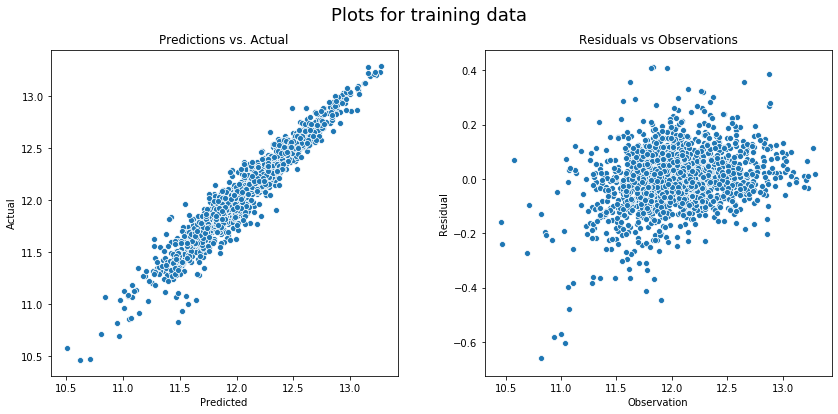

In [38]:
plot_resids(y_train, poly_preds, poly_resids, "Plots for training data")

In [39]:
# we definitely have a kind of shotgun spread to the residuals. 
# a log conversion might be in order here.

print_lr_metrics(lr_poly, X_train_pf, y_train)

The mean of residuals is:  6.255251682020075e-15
The standard dev of resids is:  0.10808700380054731
The Mean Absolute Error:  0.07920739203779678
The Sum Squared Error:  19.10137863859749
The Mean Squared Error:  0.011675659314546144
The Root Mean Squared Error:  0.10805396482566544
The Coefficient of Determination:  0.9265051551560165
The Adjusted Coefficient of Determination:  0.9130505996237966
The 10-fold cross validation score:  -0.4195864163861617


In [40]:
# thats a very odd cross val score, so lets confirm
cross_val_score(lr_poly, X_train_pf, y_train, cv=5)

array([ 0.87071096, -0.10432579, -0.22831295,  0.72753556,  0.387442  ])

In [41]:
model_score_compare(lr_poly, X_train_pf, y_train, X_test_pf, y_test)

(0.9265051551560165, 0.6464100257988269)

In [42]:
# Let's scale everything then use a LassoCV to narrow down some of these variables!

ss = StandardScaler()
Z_train = ss.fit_transform(X_train_pf)
Z_test = ss.transform(X_test_pf);
Z_kag = ss.transform(X_kag_pf);

In [43]:
# since we have no idea whatsoever what the alpha should be, lets just iterate through a big 
# space. 

lasso_alphas = np.logspace(-3, -2, 1_000)
lasso = LassoCV(alphas=lasso_alphas, cv=5, max_iter=5_000)

lasso.fit(Z_train, y_train);

In [44]:
bench_train_score = lasso.score(Z_train, y_train)
bench_train_score

0.8832733739970798

In [45]:
bench_test_score = lasso.score(Z_test, y_test)
bench_test_score

0.8769135241923129

In [46]:
lasso.alpha_

0.0011616226326085018

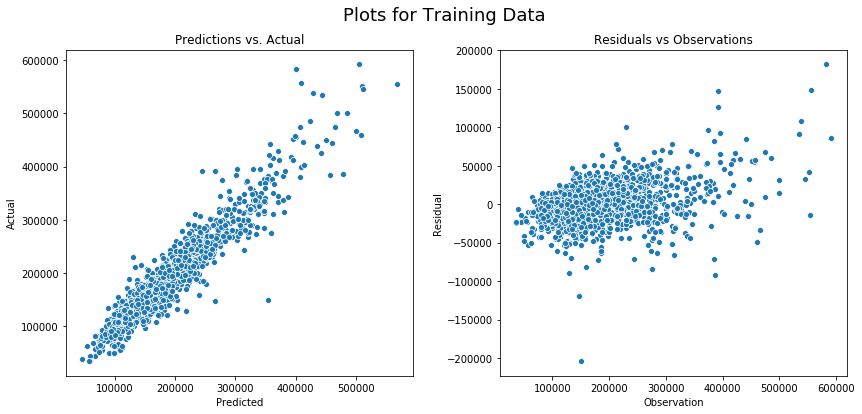

In [47]:
# definitely a major improvement! We've only sacrificed a small amount of 
# bias for a pretty big leap in the improvement of the variance
# lets take a look at the plots

preds = np.exp(lasso.predict(Z_train))
y = np.exp(y_train)
resids = y - preds

plot_resids(y, preds, resids, 'Plots for Training Data')

Now that we have a better aggreement between our training set and testing set, lets go ahead and predict values for the test.csv and submit to Kaggle to see how we're doing! 

In [48]:
submission = kaggle_raw[['Id']].copy()
submission['SalePrice'] = np.exp(lasso.predict(Z_kag))
submission.head()

,Id,SalePrice
0,2658,172087.787716
1,2718,152662.907430
2,2414,188297.347160
3,1989,117728.709546
4,625,172195.919876


In [49]:
submission.to_csv('./submissions/submission_v2_1.csv', index=False)

In [50]:
# This submission was a definite improvement over the previous!
# Now let's take a look at the variables that the model discarded and only keep those for future modeling:

lasso_betas = pd.Series(index = poly.get_feature_names(X_train.columns), data = lasso.coef_)
lasso_betas[lasso_betas != 0].sort_values()

Garage Area^2                -0.043676
rm_cond^2                    -0.040344
sf_cond^2                    -0.037666
Garage Area 1st Flr SF       -0.037112
sf_room 1st Flr SF           -0.034316
lt_qual^2                    -0.026002
pr_qual^2                    -0.024160
bsf_qual wd_qual             -0.021595
Total Bsmt SF sf_broom       -0.015366
wd_qual^2                    -0.013689
bsf_qual lt_qual             -0.013212
1st Flr SF Total Bsmt SF     -0.012592
sf_car^2                     -0.011810
Mas Vnr Area lt_qual         -0.010645
1st Flr SF bsf_qual          -0.007477
sf_room bsf_qual             -0.005531
sf_car BsmtFin SF 1          -0.005318
sf_broom BsmtFin SF 1        -0.005172
sf_cond wd_qual              -0.001265
sf_car bsf_qual              -0.001117
BsmtFin SF 1^2               -0.000910
rm_cond Wood Deck SF         -0.000566
sf_car Wood Deck SF          -0.000548
Total Bsmt SF Wood Deck SF    0.001750
Mas Vnr Area rm_cond          0.002133
sf_cond Mas Vnr Area     

In [51]:
poly_feature_list = list(lasso_betas[np.abs(lasso_betas) > 0.001].index)

### Feature Generation Continued

We now have a lot of features from the polynomial model that have been retained for future model development.

The next step will be to explore dummy features that contribute to the model. 

We'll define a function that allows us to loop through all the relevant features and compare them to our nominal scores. Festures that improve both testing scores and training scores will be retained in a list, which will then be used in a function to populate our X and get the scores and model for the dummies that were retained.

Before we do any of that though, we need to get our Kaggle test data and training data aligned for the feature generation. First, we need to do the poly transform, and select the features that we chose from our lasso regression. Then, we need to concatenate the kaggle test data to the training data so that when we generate dummies, we don't miss any columns. Finally, after dummy generation, we need to separate the kaggle test data from the training data.

In [52]:
df_poly = df[feat_list]
df_poly = poly.transform(df_poly)
df_poly = pd.DataFrame(df_poly, columns=(poly.get_feature_names(X_train.columns)))
df_poly.head()

,1,sf_qual,yr_qual,rm_qual,Gr Liv Area,sf_car,Garage Area,sf_room,1st Flr SF,Total Bsmt SF,sf_cond,bs_qual,Mas Vnr Area,sf_broom,bsf_qual,BsmtFin SF 1,rm_cond,Open Porch SF,Wood Deck SF,lt_qual,pr_qual,wd_qual,sf_qual^2,sf_qual yr_qual,sf_qual rm_qual,sf_qual Gr Liv Area,sf_qual sf_car,sf_qual Garage Area,sf_qual sf_room,sf_qual 1st Flr SF,sf_qual Total Bsmt SF,sf_qual sf_cond,sf_qual bs_qual,sf_qual Mas Vnr Area,sf_qual sf_broom,sf_qual bsf_qual,sf_qual BsmtFin SF 1,sf_qual rm_cond,sf_qual Open Porch SF,sf_qual Wood Deck SF,sf_qual lt_qual,sf_qual pr_qual,sf_qual wd_qual,yr_qual^2,yr_qual rm_qual,yr_qual Gr Liv Area,yr_qual sf_car,yr_qual Garage Area,yr_qual sf_room,yr_qual 1st Flr SF,...,Mas Vnr Area Open Porch SF,Mas Vnr Area Wood Deck SF,Mas Vnr Area lt_qual,Mas Vnr Area pr_qual,Mas Vnr Area wd_qual,sf_broom^2,sf_broom bsf_qual,sf_broom BsmtFin SF 1,sf_broom rm_cond,sf_broom Open Porch SF,sf_broom Wood Deck SF,sf_broom lt_qual,sf_broom pr_qual,sf_broom wd_qual,bsf_qual^2,bsf_qual BsmtFin SF 1,bsf_qual rm_cond,bsf_qual Open Porch SF,bsf_qual Wood Deck SF,bsf_qual lt_qual,bsf_qual pr_qual,bsf_qual wd_qual,BsmtFin SF 1^2,BsmtFin SF 1 rm_cond,BsmtFin SF 1 Open Porch SF,BsmtFin SF 1 Wood Deck SF,BsmtFin SF 1 lt_qual,BsmtFin SF 1 pr_qual,BsmtFin SF 1 wd_qual,rm_cond^2,rm_cond Open Porch SF,rm_cond Wood Deck SF,rm_cond lt_qual,rm_cond pr_qual,rm_cond wd_qual,Open Porch SF^2,Open Porch SF Wood Deck SF,Open Porch SF lt_qual,Open Porch SF pr_qual,Open Porch SF wd_qual,Wood Deck SF^2,Wood Deck SF lt_qual,Wood Deck SF pr_qual,Wood Deck SF wd_qual,lt_qual^2,lt_qual pr_qual,lt_qual wd_qual,pr_qual^2,pr_qual wd_qual,wd_qual^2
0,1.0,8874.0,12030.0,36.0,1479.0,950.0,475.0,8874.0,725.0,725.0,11832.0,4350.0,289.0,4437.0,3198.0,533.0,48.0,44.0,0.0,81102.0,264.0,0.0,78747876.0,106754220.0,319464.0,13124646.0,8430300.0,4215150.0,78747876.0,6433650.0,6433650.0,104997168.0,38601900.0,2564586.0,39373938.0,28379052.0,4729842.0,425952.0,390456.0,0.0,7.196991e+08,2342736.0,0.0,144720900.0,433080.0,17792370.0,11428500.0,5714250.0,106754220.0,8721750.0,...,12716.0,0.0,23438478.0,76296.0,0.0,19686969.0,14189526.0,2364921.0,212976.0,195228.0,0.0,359849574.0,1171368.0,0.0,10227204.0,1704534.0,153504.0,140712.0,0.0,259364196.0,844272.0,0.0,284089.0,25584.0,23452.0,0.0,43227366.0,140712.0,0.0,2304.0,2112.0,0.0,3892896.0,12672.0,0.0,1936.0,0.0,3568488.0,11616.0,0.0,0.0,0.0,0.0,0.0,6.577534e+09,21410928.0,0.0,69696.0,0.0,0.0
1,1.0,14854.0,13979.0,56.0,2122.0,1118.0,559.0,16976.0,913.0,913.0,10610.0,6391.0,132.0,8488.0,4459.0,637.0,40.0,74.0,0.0,80444.0,518.0,0.0,220641316.0,207644066.0,831824.0,31520188.0,16606772.0,8303386.0,252161504.0,13561702.0,13561702.0,157600940.0,94931914.0,1960728.0,126080752.0,66233986.0,9461998.0,594160.0,1099196.0,0.0,1.194915e+09,7694372.0,0.0,195412441.0,782824.0,29663438.0,15628522.0,7814261.0,237307504.0,12762827.0,...,9768.0,0.0,10618608.0,68376.0,0.0,72046144.0,37847992.0,5406856.0,339520.0,628112.0,0.0,682808672.0,4396784.0,0.0,19882681.0,2840383.0,178360.0,329966.0,0.0,358699796.0,2309762.0,0.0,405769.0,25480.0,47138.0,0.0,51242828.0,329966.0,0.0,1600.0,2960.0,0.0,3217760.0,20720.0,0.0,5476.0,0.0,5952856.0,38332.0,0.0,0.0,0.0,0.0,0.0,6.471237e+09,41669992.0,0.0,268324.0,0.0,0.0
2,1.0,5285.0,10035.0,25.0,1057.0,246.0,246.0,5285.0,1057.0,1057.0,7399.0,5285.0,0.0,3171.0,3655.0,731.0,35.0,52.0,0.0,39610.0,260.0,0.0,27931225.0,53034975.0,132125.0,5586245.0,1300110.0,1300110.0,27931225.0,5586245.0,5586245.0,39103715.0,27931225.0,0.0,16758735.0,19316675.0,3863335.0,184975.0,274820.0,0.0,2.093388e+08,1374100.0,0.0,100701225.0,250875.0,10606995.0,2468610.0,2468610.0,53034975.0,10606995.0,...,0.0,0.0,0.0,0.0,0.0,10055241.0,11590005.0,2318001.0,110985.0,164892.0,0.0,125603310.0,824460.0,0.0,13359025.0,2671805.0,127925.0,190060.0,0.0,144774550.0,950300.0,0.0,534361.0,25585.0,38012.0,0.0,28954910.0,190060.0,0.0,1225.0,1820.0,0.0,1386350.0,9100.0,0.0,2704.0,0.0,2059720.0,13520.0,0.0,0.0,0.0,0.0,0.0,1.568952e+09,10298600.0,0.0,67600.0,0.

In [53]:
X_refined = df_poly[poly_feature_list]
X_refined.index = list(range(len(X_refined)))
X_refined.shape

(2046, 43)

In [54]:
# we already have the kag data transformed, so we just need to grab the features we want:
X_kag = X_kag_pf[poly_feature_list]
X_kag.index = list(range(len(X_kag)))
X_kag.shape

(878, 43)

In [55]:
# now lets get the dummies. we'll concatenate the kaggle test set, then seperate
# so that we can make sure there are the same number of dummy columns. Code inspired by:
# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data

# first, we need to concatenate the original kaggle test data to the original dataframe:

data_df = df.drop(columns='SalePrice')
kaggle_df = kg
data_all = pd.concat([data_df, kaggle_df], axis=0, ignore_index=True)
data_all.shape

(2924, 93)

In [56]:
# now we get the number of items in our test set with refined features:
X_ref_rows = len(X_refined)

In [57]:
# now we can concatenate the refined training data to the refined kaggle test data:
data_ref = pd.concat([X_refined, X_kag], axis=0, ignore_index=True)
data_ref.shape

(2924, 43)

In [58]:
# get the dummies from the training/kaggle dataset made above. We'll use 'Sale Type' as a model.
data_dummy = pd.get_dummies(data_all['TotRms AbvGrd'], drop_first=True)
data_dummy.shape

(2924, 13)

In [59]:
# concat the data and the dummies:
data_w_dum = pd.concat([data_ref, data_dummy], axis=1, ignore_index=True)

In [60]:
# now seperate back into seperate training and kaggle test sets:
X_ref_dum = data_w_dum[:X_ref_rows]
X_kag_dum = data_w_dum[X_ref_rows:]

In [61]:
# before we go any further, let's automate this bit:

def add_dummies(dummy, X_data, all_data=data_all, rows=X_ref_rows):
    '''This function will return a training dataset and a test dataset with 'dummy' one-hot encoded from all_data
    
    Keyword Arguments:
    dummy -- the column or list of columns to be One Hot Encoded
    X_data -- the combined train/test dataset with desired X features
    all_data -- the combined original dataset
    row -- the row number at which to split the dataset
    
    Returns:
    train_ref -- the training portion of the dataset with the new dummy encoded
    test_ref -- the testing portion of the dataset with the new dummy encoded'''
    
    
    data_dummy = pd.get_dummies(all_data[dummy], prefix=dummy, drop_first=True)
    data_w_dum = pd.concat([X_data, data_dummy], axis=1, ignore_index=True)
    train_ref = data_w_dum[:rows]
    test_ref = data_w_dum[rows:]
    
    return train_ref, test_ref, data_w_dum

In [62]:
# just a quick reminder, data_all is all of the cleaned original data (train set + test set)
# data_ref is all the data with the features we have selected (train set + test set)

In [63]:
# looks like the only things left are ordinal, nominal, or discrete
# lets create some benchmarks from the linear model with just the refined features and start looping through it!

y = df['ln_price']
lr = LinearRegression()
dummy_list = []
dummy_dict = {}
X_train, X_test, y_train, y_test = train_test_split(X_refined, y, test_size=0.2, random_state=r_state)

lr.fit(X_train, y_train)

bench_train_score = lr.score(X_train, y_train)
bench_test_score = lr.score(X_test, y_test)
bench_cross_val = cross_val_score(lr, X_train, y_train, cv=10).mean()
print(bench_train_score, bench_test_score, bench_cross_val)

0.8872280343204565 0.8675605207528536 0.8656068078856054


In [64]:
data_loop = data_all.drop(columns=feat_list)
data_loop.drop(columns=[
    'BsmtFin SF 2', 
    'Lot Frontage',
    'Lot Area',
    'yr_cond',
    'Bsmt Unf SF',
    'Low Qual Fin SF',
    'Enclosed Porch',
    '3Ssn Porch',
    'Screen Porch',
    'Pool Area',
    '2nd Flr SF',
    'Misc Val'
], inplace=True)
data_loop.head()

,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Mo Sold,Yr Sold,Sale Type,ln_price
0,60,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,Gd,TA,CBlock,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,TA,TA,Y,NaN,NaN,NaN,3,2010,WD,11.779129
1,60,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,TA,TA,Y,NaN,NaN,NaN,4,2009,WD,12.301383
2,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,TA,Gd,CBlock,TA,TA,No,GLQ,Unf,GasA,TA,Y,SBrkr,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,TA,TA,Y,NaN,NaN,NaN,1,2010,WD,11.599103
3,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,TA,TA,Y,NaN,NaN,NaN,4,2010,WD,12.066811
4,50,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,TA,TA,PConc,Fa,Gd,No,Unf,Unf,GasA,TA,Y,SBrkr,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,TA,TA,N,NaN,NaN,NaN,3,2010,WD,11.838626


In [65]:
# here we'll iterate through a loop to see which features improve our bench scores
# which were derived from the Lasso regression earlier. We'll save the features to a list
# then explore them further afterwards

for column in data_loop.columns:
    
    # here we get the dummies for the column in question
    X_dum, kag_dum, data_ref_dum = add_dummies(column, data_ref, data_all)
    
    # train/test split the data and fit it
    X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, random_state=r_state)
    lr.fit(X_train, y_train)
    
    # store our experimental scores
    exper_train_score = lr.score(X_train, y_train)
    exper_test_score = lr.score(X_test, y_test)
    exper_cross = cross_val_score(lr, X_train, y_train, cv=10).mean()
    # get the difference between the experimental score and the bench score
    compare_train = round((exper_train_score - bench_train_score)*100, 5)
    compare_test = round((exper_test_score - bench_test_score)*100, 5)
    compare_cross = round((exper_cross - bench_cross_val)*100, 5)
    # if the experimental scores don't give us too much of a hit to bias and improve variance:
    if compare_cross > 0:
        dummy_dict.update({column : 
                          [compare_train,
                          compare_test,
                          compare_cross]})
        dummy_list.append(column)
        

In [66]:
dummy_dict

{'MS SubClass': [1.21023, 1.07994, 0.13589],
 'MS Zoning': [1.10511, 1.36121, 0.54569],
 'Street': [0.15604, 0.00047, 0.08836],
 'Alley': [0.00248, 0.02403, 0.00108],
 'Lot Shape': [0.13881, 0.08764, 0.05166],
 'Land Contour': [0.19234, -0.08131, 0.46736],
 'Utilities': [0.01312, -0.00904, 0.01604],
 'Lot Config': [0.06331, 0.05262, 0.05787],
 'Land Slope': [0.02208, -0.02279, 0.0813],
 'Neighborhood': [2.73145, 2.05479, 2.39456],
 'Condition 1': [0.54836, 0.58108, 0.45785],
 'Bldg Type': [0.18234, 0.23352, 0.15824],
 'Overall Qual': [1.42641, 1.54633, 1.19198],
 'Overall Cond': [0.81844, -0.08884, 0.67062],
 'Year Built': [3.83031, 2.98032, 1.06512],
 'Year Remod/Add': [1.74651, 1.06492, 0.4324],
 'Exterior 1st': [1.0226, 0.71519, 0.21503],
 'Exterior 2nd': [0.77939, 0.54548, 0.17405],
 'Mas Vnr Type': [0.07723, 0.0527, 0.08499],
 'Exter Qual': [0.76987, 0.72816, 0.88243],
 'Exter Cond': [0.29361, 0.03862, 0.22834],
 'Foundation': [1.16955, 2.10163, 0.71449],
 'Bsmt Qual': [1.08903, 0

In [67]:
# now we have a dictionary that contains the feature, and a list of how much each feature improved our model
# lets add some features!

# lets automate adding some of them

def add_dummies_fit_plot(dummy, data_ref, data=data_all, rows=X_ref_rows):
    '''This function will automatically add a dummy column, fit the data to a linear regrssion,
    evaluate it, plot the predictions and residuals, then return the refined dataset with
    dummies and the kaggle test data with dummies
    
    Keyword Arguments: 
    dummy -- the name of the column for which we want to create dummies
    data_ref -- the X dataset that contains training data + kaggle data as well as the features 
                we have decided to keep
    data -- the full dataset, defaulted to data_all
    rows -- the number of rows of training data 
            (where we will divide the training data from the kaggle test data)
            
    Returns: 
    model -- the fitted Linear Regression
    data_w_dum -- the refined dataset with the new dummies
    df_kag -- the kaggle test dataset with the new dummies'''
    
    data_dummies = pd.get_dummies(data_all[dummy], prefix=str(dummy), drop_first=True)
    data_w_dum = pd.concat([data_ref, data_dummies], axis=1)
    df_ref = data_w_dum[:rows]
    df_kag = data_w_dum[rows:]
    
    X = df_ref
    y = np.log(df['SalePrice'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    lr, preds, resids = fit_linear_reg(X_train, y_train)
    print('\n')
    print(dummy)
    print_lr_metrics(lr, X_train, y_train)
   
    train_score = str(lr.score(X_train, y_train))
    test_score = str(lr.score(X_test, y_test))
 
    print('\n')
    print("Train Score: " + train_score)
    print("Test Score: " + test_score)
    print('\n')
    y_train_exp = np.exp(y_train)
    preds_exp = np.exp(preds)
    resids_exp = y_train_exp - preds_exp
    
    plot_resids(y_train_exp, preds_exp, resids_exp, "Plots for Training Data")
    
    y_test_preds = lr.predict(X_test)
    y_test_exp = np.exp(y_test)
    y_test_preds_exp = np.exp(y_test_preds)
    test_resids = y_test_exp - y_test_preds_exp
    
    plot_resids(y_test_exp, y_test_preds_exp, test_resids, "Plots for Testing Data")
    
    return lr, data_w_dum, df_kag



Neighborhood
The mean of residuals is:  1.429988971570984e-15
The standard dev of resids is:  0.11684054114355054
The Mean Absolute Error:  0.08412404657309722
The Sum Squared Error:  22.320549209463472
The Mean Squared Error:  0.01364336748744711
The Root Mean Squared Error:  0.11680482647325456
The Coefficient of Determination:  0.9162111827709619
The Adjusted Coefficient of Determination:  0.9124634401472989
The 10-fold cross validation score:  0.8970058779881758


Train Score: 0.9162111827709619
Test Score: 0.8935138118072798




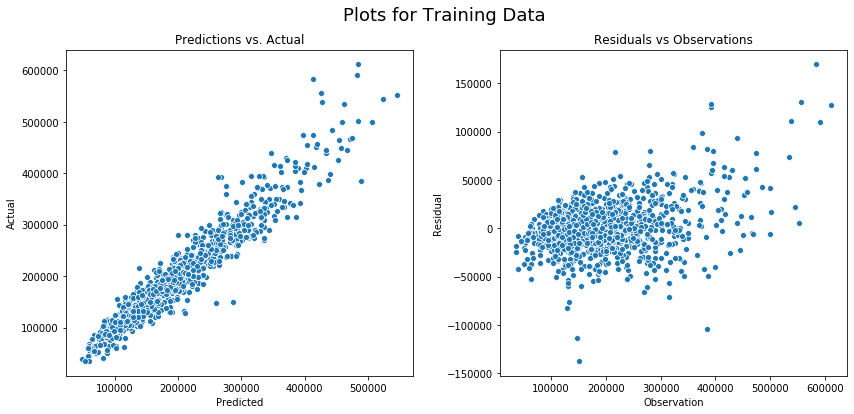

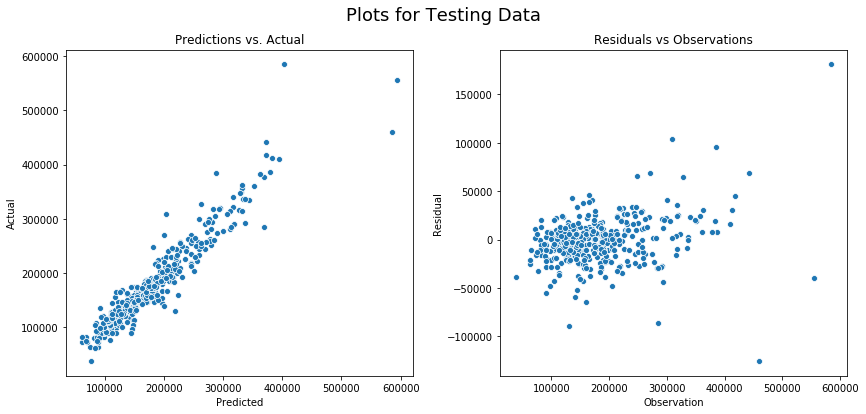

In [68]:
# let's start with the low hanging fruit:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Neighborhood', data_ref)

In [69]:
data_ref = data_w_dum



Overall Qual
The mean of residuals is:  1.4462758619077834e-15
The standard dev of resids is:  0.11367477731941297
The Mean Absolute Error:  0.08138103044529017
The Sum Squared Error:  21.127396422740574
The Mean Squared Error:  0.01291405649311771
The Root Mean Squared Error:  0.11364003032874335
The Coefficient of Determination:  0.920690143384111
The Adjusted Coefficient of Determination:  0.916663486139474
The 10-fold cross validation score:  0.9017747211319577


Train Score: 0.920690143384111
Test Score: 0.8991625946229652




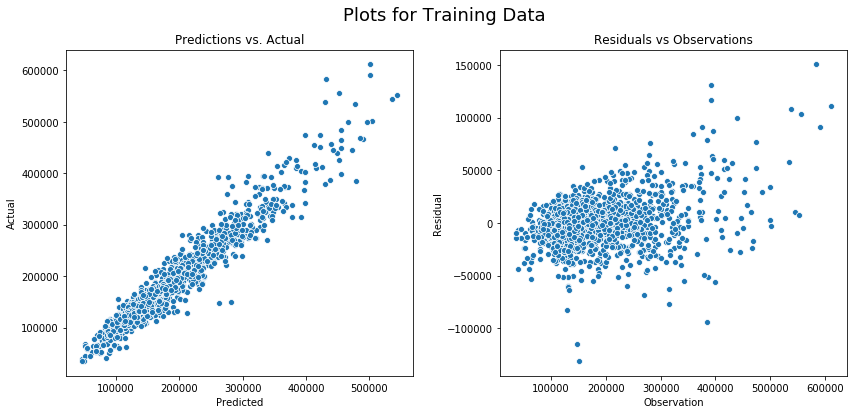

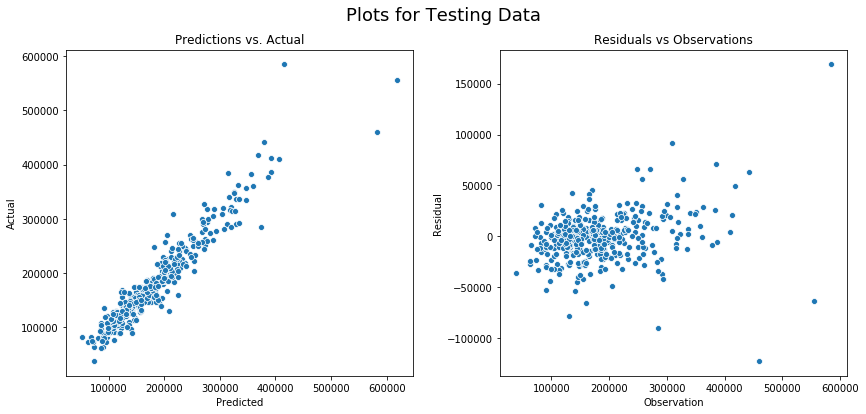

In [70]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Overall Qual', data_ref)

In [71]:
data_ref = data_w_dum



Year Built
The mean of residuals is:  1.0760205549178778e-15
The standard dev of resids is:  0.10236241134358859
The Mean Absolute Error:  0.07352137956290089
The Sum Squared Error:  17.131633423681038
The Mean Squared Error:  0.010471658571932175
The Root Mean Squared Error:  0.10233112220596516
The Coefficient of Determination:  0.9356897857529827
The Adjusted Coefficient of Determination:  0.9269303681071068
The 10-fold cross validation score:  0.9022452065876732


Train Score: 0.9356897857529827
Test Score: 0.9070276944999556




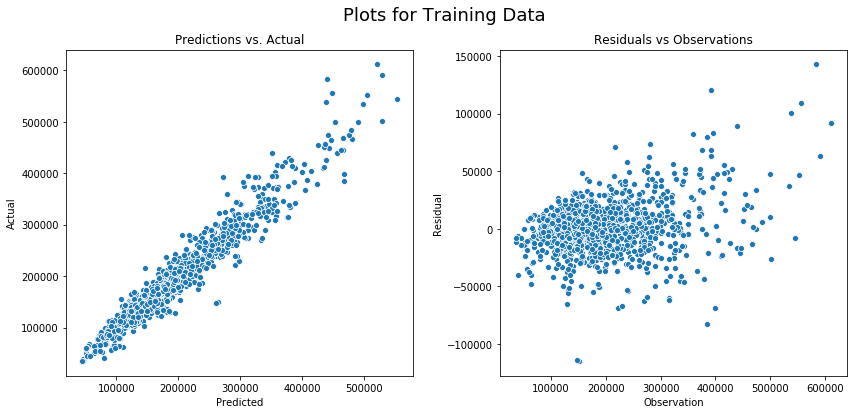

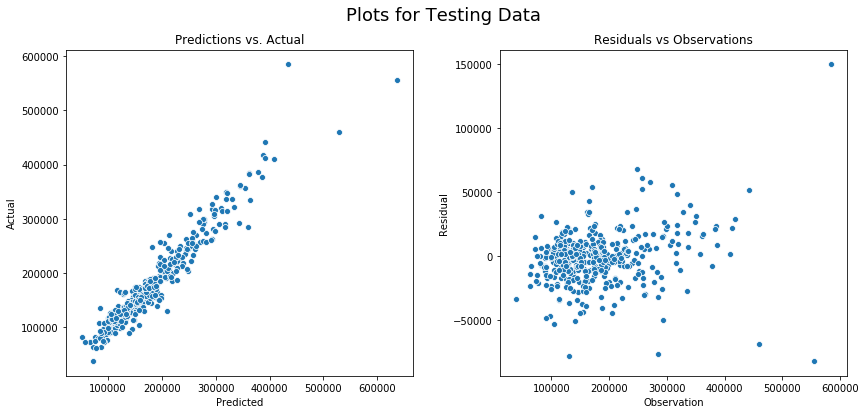

In [72]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Year Built', data_ref)

In [73]:
data_ref = data_w_dum



Bsmt Qual
The mean of residuals is:  1.8045874493173695e-15
The standard dev of resids is:  0.10219742202501882
The Mean Absolute Error:  0.07321070262729222
The Sum Squared Error:  17.076451867095287
The Mean Squared Error:  0.010437929014116923
The Root Mean Squared Error:  0.10216618331971163
The Coefficient of Determination:  0.9358969310752498
The Adjusted Coefficient of Determination:  0.9269627054411383
The 10-fold cross validation score:  0.9019207410860058


Train Score: 0.9358969310752498
Test Score: 0.9072850376547394




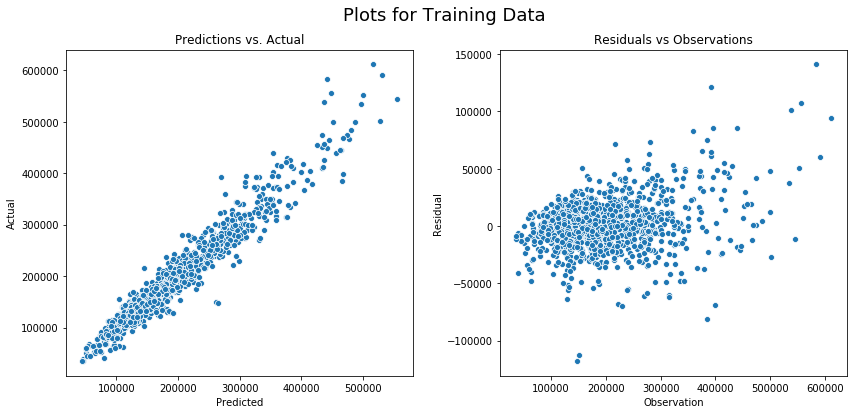

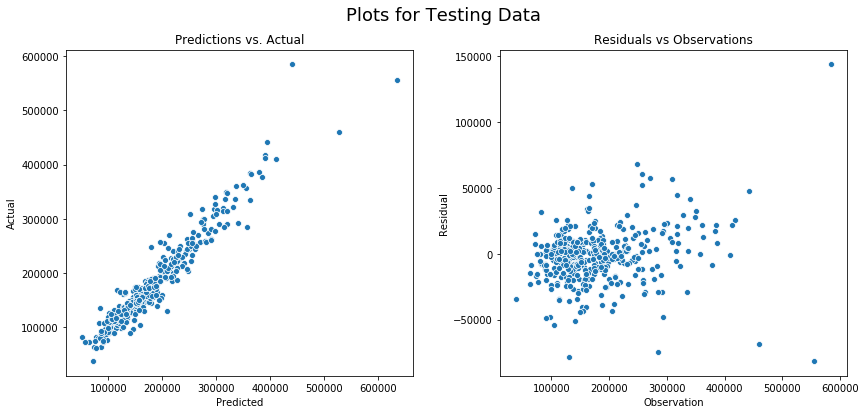

In [74]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Bsmt Qual', data_ref)

In [75]:
data_ref = data_w_dum



Heating QC
The mean of residuals is:  6.829636014564533e-16
The standard dev of resids is:  0.10178643181528235
The Mean Absolute Error:  0.07267838057426788
The Sum Squared Error:  16.93938104225847
The Mean Squared Error:  0.010354144891356033
The Root Mean Squared Error:  0.1017553187374303
The Coefficient of Determination:  0.9364114794486751
The Adjusted Coefficient of Determination:  0.9273464492652577
The 10-fold cross validation score:  0.9024920438815919


Train Score: 0.9364114794486751
Test Score: 0.9089510068165919




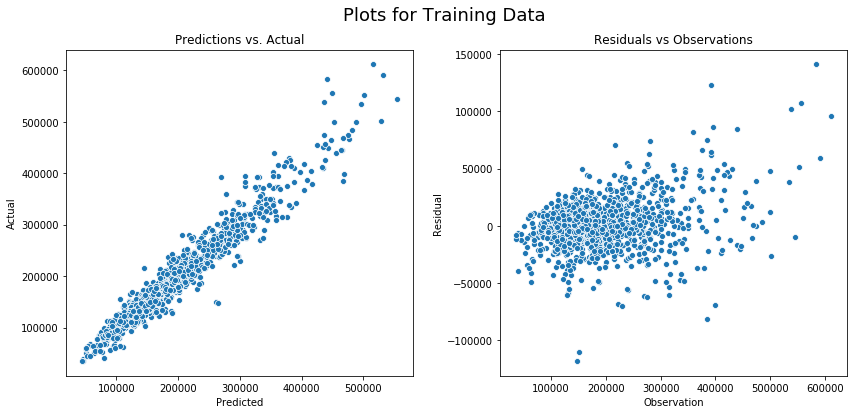

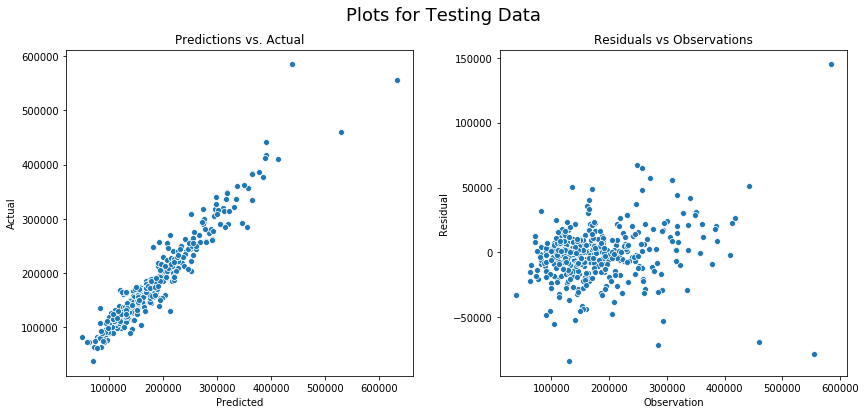

In [76]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Heating QC', data_ref)

In [77]:
data_ref = data_w_dum



Kitchen Qual
The mean of residuals is:  1.7068661072965733e-15
The standard dev of resids is:  0.1010318518989719
The Mean Absolute Error:  0.07203965342513644
The Sum Squared Error:  16.689156385452012
The Mean Squared Error:  0.01020119583462837
The Root Mean Squared Error:  0.1010009694737054
The Coefficient of Determination:  0.9373507945093665
The Adjusted Coefficient of Determination:  0.9282190252437381
The 10-fold cross validation score:  0.9032116944928685


Train Score: 0.9373507945093665
Test Score: 0.9099563577267534




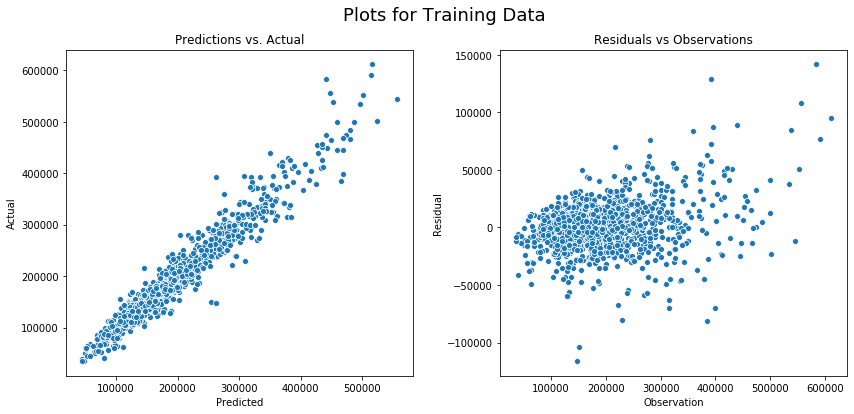

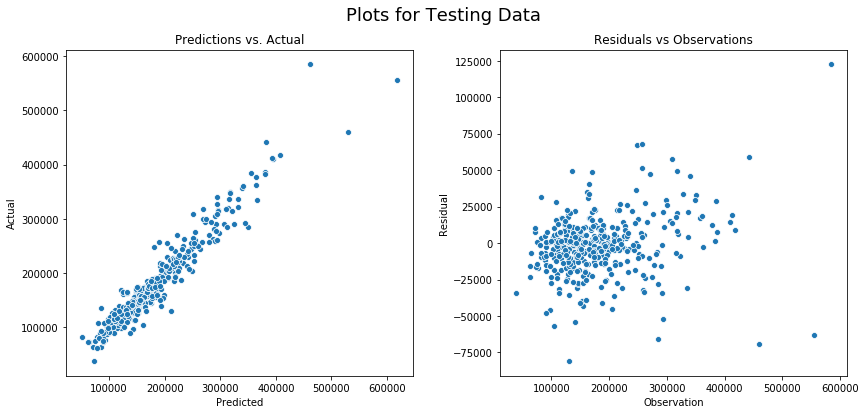

In [78]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Kitchen Qual', data_ref)

In [79]:
data_ref = data_w_dum



Overall Cond
The mean of residuals is:  9.511543956690827e-16
The standard dev of resids is:  0.10041046695926194
The Mean Absolute Error:  0.07163965200769916
The Sum Squared Error:  16.484498165587446
The Mean Squared Error:  0.01007609912321971
The Root Mean Squared Error:  0.10037977447284742
The Coefficient of Determination:  0.9381190583194426
The Adjusted Coefficient of Determination:  0.9286995492264191
The 10-fold cross validation score:  0.9019564127378572


Train Score: 0.9381190583194426
Test Score: 0.9117988126533686




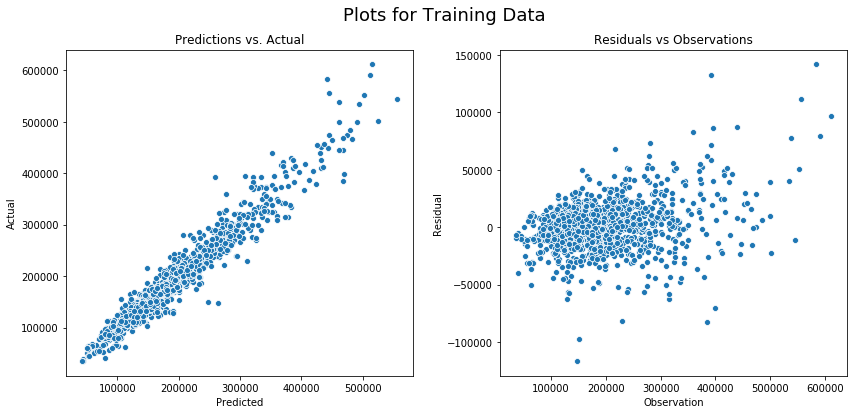

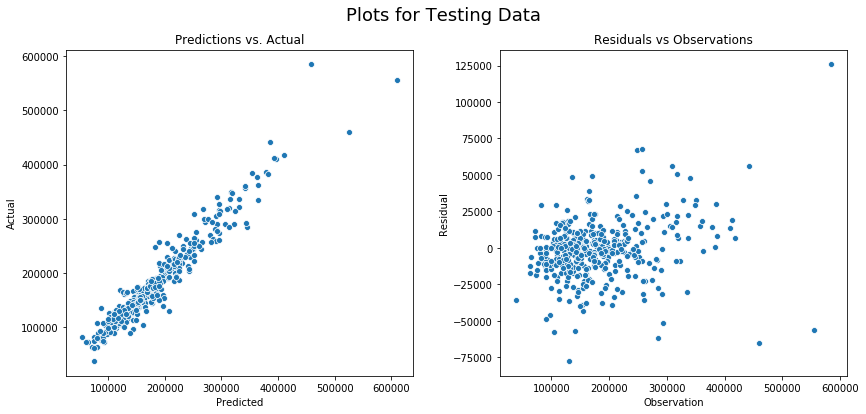

In [80]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Overall Cond', data_ref)

In [81]:
data_ref = data_w_dum



Central Air
The mean of residuals is:  1.225859946016432e-15
The standard dev of resids is:  0.10009194545793842
The Mean Absolute Error:  0.07131924263487853
The Sum Squared Error:  16.380079986982285
The Mean Squared Error:  0.010012273830673768
The Root Mean Squared Error:  0.1000613503340514
The Coefficient of Determination:  0.9385110323520004
The Adjusted Coefficient of Determination:  0.929101225596277
The 10-fold cross validation score:  0.901853140297314


Train Score: 0.9385110323520004
Test Score: 0.914337983214395




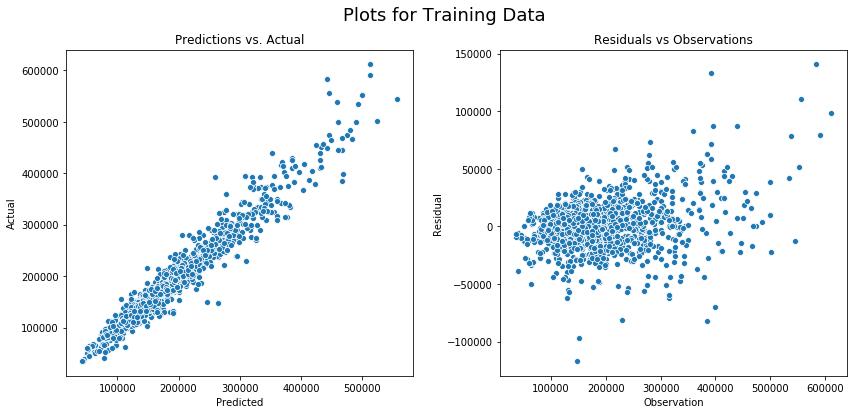

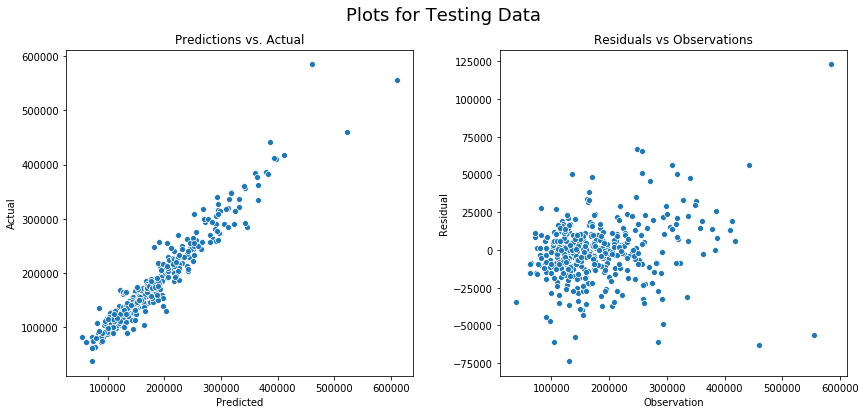

In [82]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Central Air', data_ref)

In [83]:
data_ref = data_w_dum



Bsmt Exposure
The mean of residuals is:  3.3116677018158706e-16
The standard dev of resids is:  0.09907917015374725
The Mean Absolute Error:  0.07069231969847403
The Sum Squared Error:  16.05027500191076
The Mean Squared Error:  0.009810681541510245
The Root Mean Squared Error:  0.09904888460507895
The Coefficient of Determination:  0.9397490829642885
The Adjusted Coefficient of Determination:  0.9303814492202203
The 10-fold cross validation score:  0.903128731271042


Train Score: 0.9397490829642885
Test Score: 0.9157987543655558




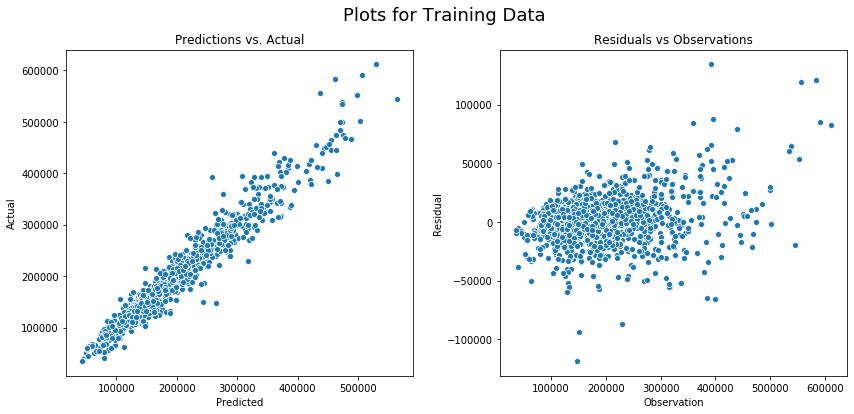

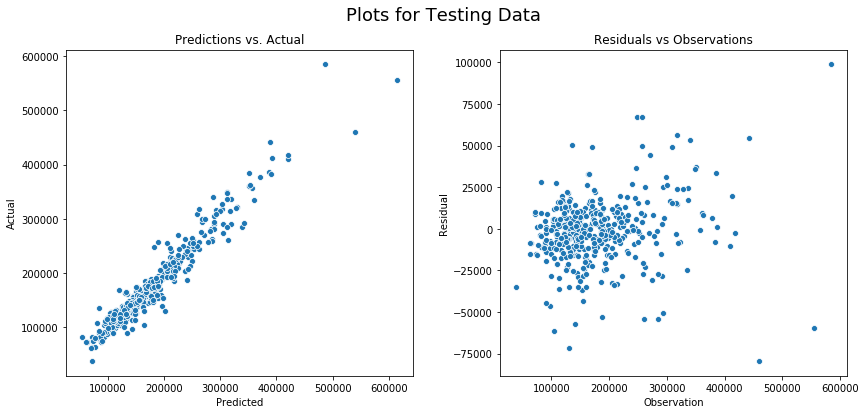

In [84]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Bsmt Exposure', data_ref)

In [85]:
data_ref = data_w_dum



Condition 1
The mean of residuals is:  3.680837216116656e-16
The standard dev of resids is:  0.0971323839502423
The Mean Absolute Error:  0.06946557615174988
The Sum Squared Error:  15.425734519386694
The Mean Squared Error:  0.009428933080309716
The Root Mean Squared Error:  0.09710269347608086
The Coefficient of Determination:  0.9420935372987794
The Adjusted Coefficient of Determination:  0.9327099740465561
The 10-fold cross validation score:  0.9066396792109523


Train Score: 0.9420935372987794
Test Score: 0.9201941265802286




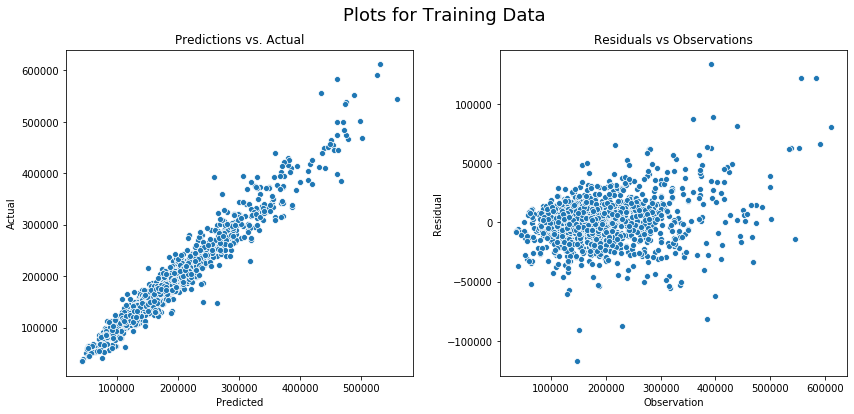

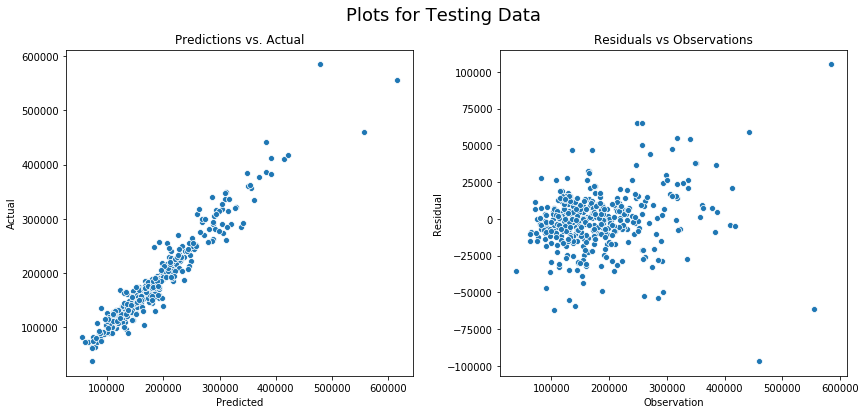

In [86]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Condition 1', data_ref)

In [87]:
data_ref = data_w_dum



Pool QC
The mean of residuals is:  7.6439805314045005e-16
The standard dev of resids is:  0.09699511220552984
The Mean Absolute Error:  0.06932530083729611
The Sum Squared Error:  15.382164679533032
The Mean Squared Error:  0.009402301148858821
The Root Mean Squared Error:  0.09696546369124845
The Coefficient of Determination:  0.9422570935497452
The Adjusted Coefficient of Determination:  0.9327566580867759
The 10-fold cross validation score:  0.9052388170673737


Train Score: 0.9422570935497452
Test Score: 0.9200967151183332




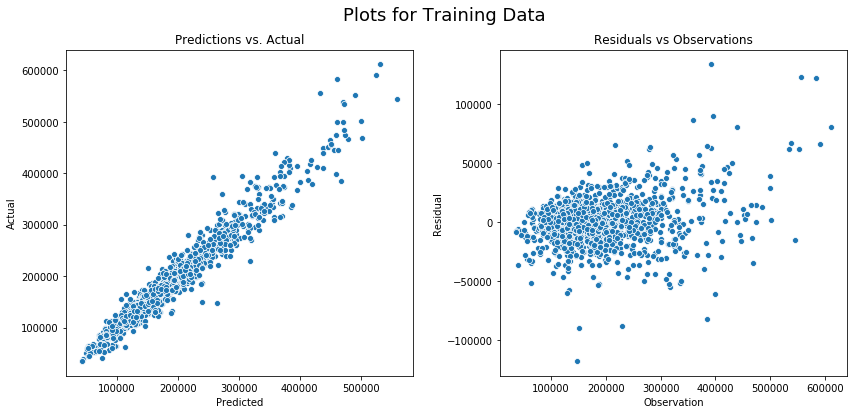

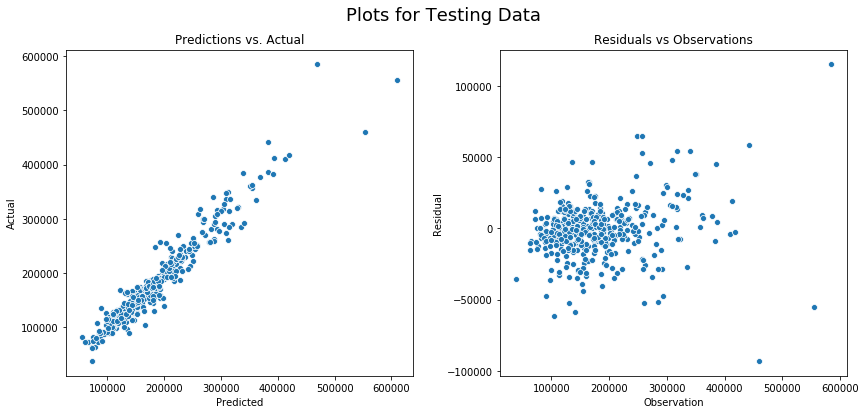

In [88]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Pool QC', data_ref)

In [89]:
data_ref = data_w_dum



Heating
The mean of residuals is:  -3.213946359795074e-16
The standard dev of resids is:  0.09688679923718002
The Mean Absolute Error:  0.06919065365637175
The Sum Squared Error:  15.347829801605888
The Mean Squared Error:  0.0093813140596613
The Root Mean Squared Error:  0.0968571838309441
The Coefficient of Determination:  0.9423859827981333
The Adjusted Coefficient of Determination:  0.9326669634560029
The 10-fold cross validation score:  0.9057614781076003


Train Score: 0.9423859827981333
Test Score: 0.9215245530564076




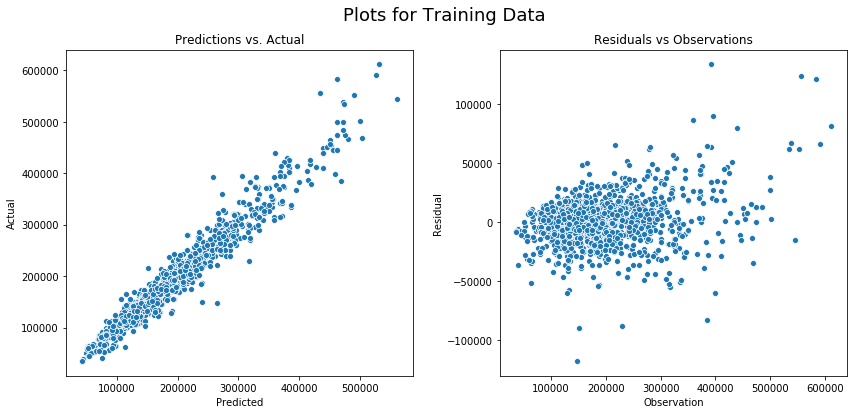

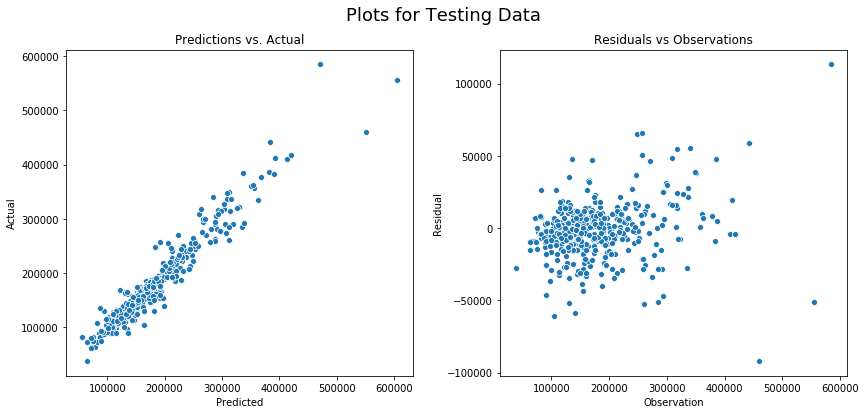

In [90]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Heating', data_ref)

In [91]:
data_ref = data_w_dum



Full Bath
The mean of residuals is:  1.659091228975295e-15
The standard dev of resids is:  0.09659397900229852
The Mean Absolute Error:  0.069175159319373
The Sum Squared Error:  15.255198734476773
The Mean Squared Error:  0.009324693602980912
The Root Mean Squared Error:  0.09656445310247924
The Coefficient of Determination:  0.9427337093473583
The Adjusted Coefficient of Determination:  0.9328814442888393
The 10-fold cross validation score:  0.9056286877821338


Train Score: 0.9427337093473583
Test Score: 0.9219799805669421




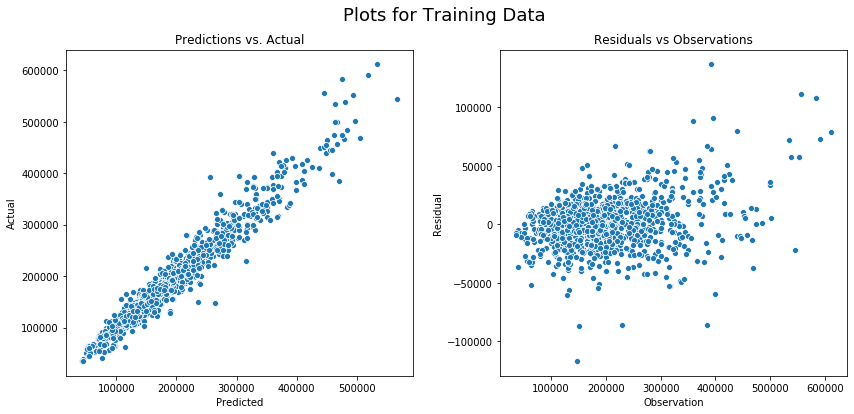

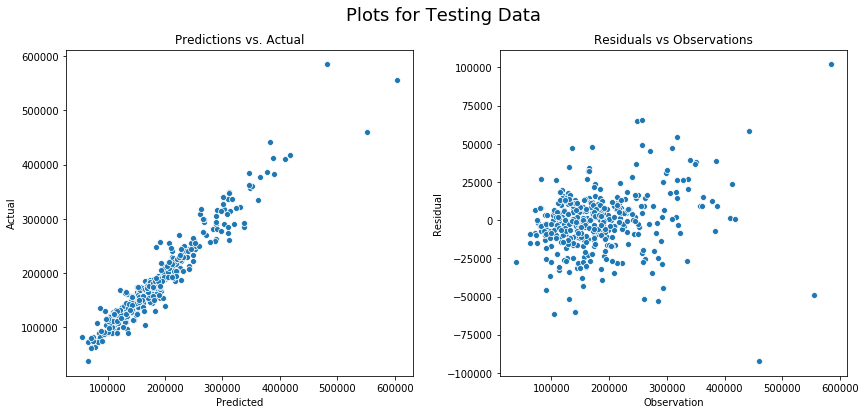

In [92]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Full Bath', data_ref)

In [93]:
data_ref = data_w_dum



Bsmt Full Bath
The mean of residuals is:  7.893712849902091e-16
The standard dev of resids is:  0.09614872506709551
The Mean Absolute Error:  0.06907742601077879
The Sum Squared Error:  15.114883937865642
The Mean Squared Error:  0.009238926612387312
The Root Mean Squared Error:  0.09611933526813068
The Coefficient of Determination:  0.9432604352239239
The Adjusted Coefficient of Determination:  0.9333554680970657
The 10-fold cross validation score:  0.9057277664620788


Train Score: 0.9432604352239239
Test Score: 0.9208621411306871




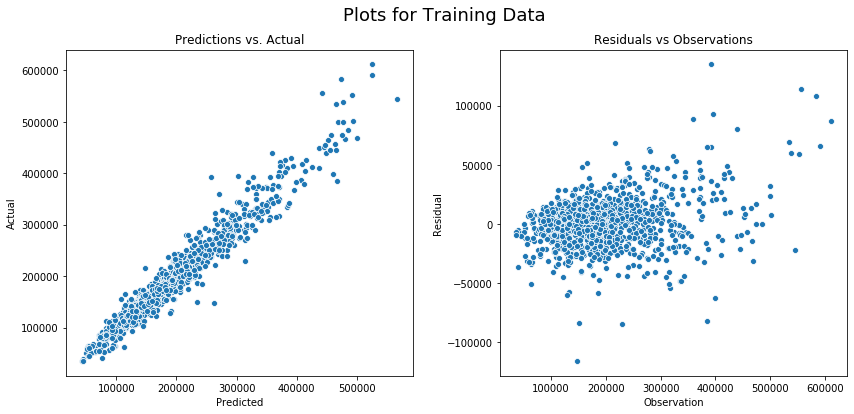

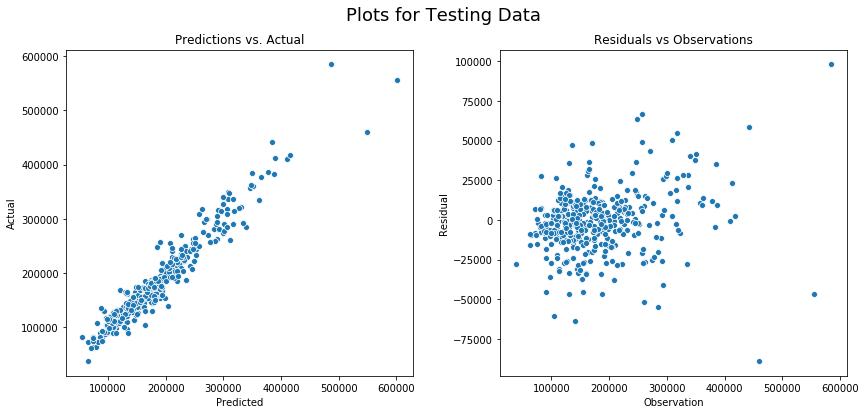

In [94]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Bsmt Full Bath', data_ref)

In [95]:
data_ref = data_w_dum



Fireplaces
The mean of residuals is:  1.3746135444258663e-15
The standard dev of resids is:  0.0949601223815538
The Mean Absolute Error:  0.06788757176187137
The Sum Squared Error:  14.74348961784667
The Mean Squared Error:  0.00901191296934393
The Root Mean Squared Error:  0.09493109590299656
The Coefficient of Determination:  0.9446546074957594
The Adjusted Coefficient of Determination:  0.9348056795789385
The 10-fold cross validation score:  0.9078512407161925


Train Score: 0.9446546074957594
Test Score: 0.9230064752096696




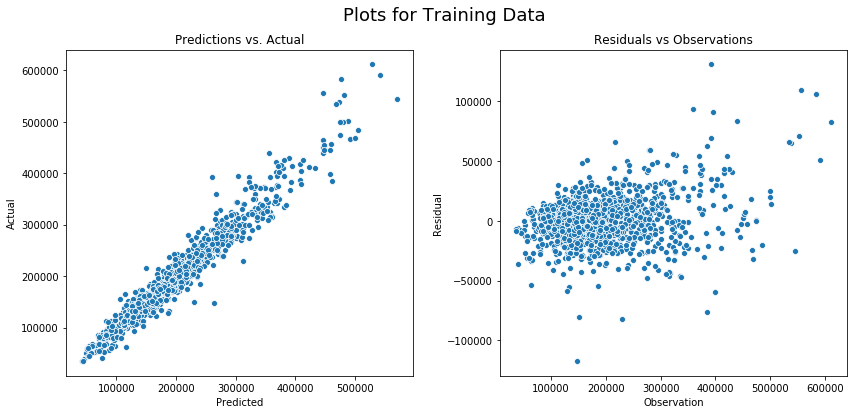

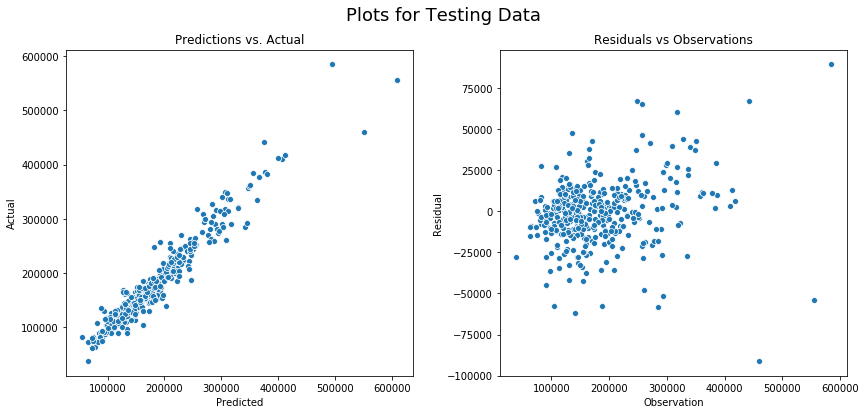

In [96]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Fireplaces', data_ref)

In [97]:
data_ref = data_w_dum



Functional
The mean of residuals is:  2.431089830939585e-15
The standard dev of resids is:  0.09284107439206443
The Mean Absolute Error:  0.06615266224304363
The Sum Squared Error:  14.09282542913609
The Mean Squared Error:  0.008614196472577072
The Root Mean Squared Error:  0.09281269564330664
The Coefficient of Determination:  0.9470971272686257
The Adjusted Coefficient of Determination:  0.9373669826822615
The 10-fold cross validation score:  0.9095596925831965


Train Score: 0.9470971272686257
Test Score: 0.9240951627609728




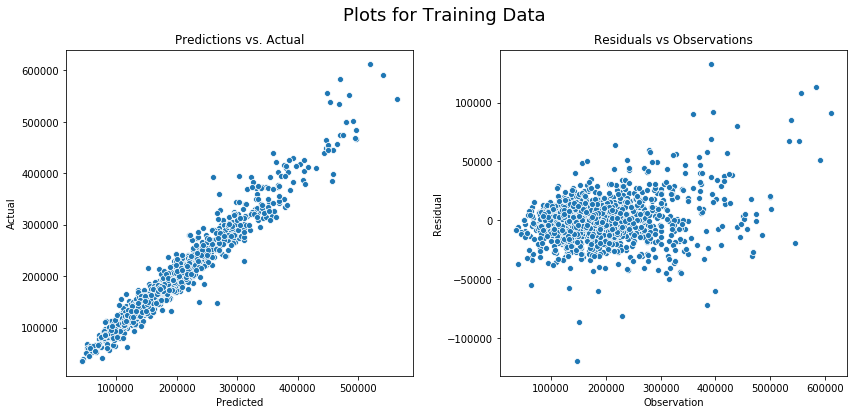

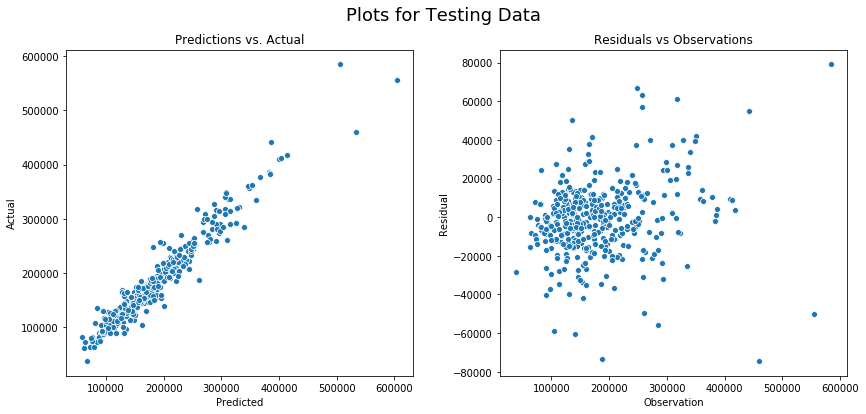

In [98]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Functional', data_ref)

In [99]:
data_ref = data_w_dum



Fireplace Qu
The mean of residuals is:  9.272669565084438e-16
The standard dev of resids is:  0.09278637285472777
The Mean Absolute Error:  0.0660986083973561
The Sum Squared Error:  14.076223464622249
The Mean Squared Error:  0.008604048572507487
The Root Mean Squared Error:  0.09275801082659917
The Coefficient of Determination:  0.9471594491656918
The Adjusted Coefficient of Determination:  0.9372590409483705
The 10-fold cross validation score:  0.9091462654647211


Train Score: 0.9471594491656918
Test Score: 0.9239070555620917




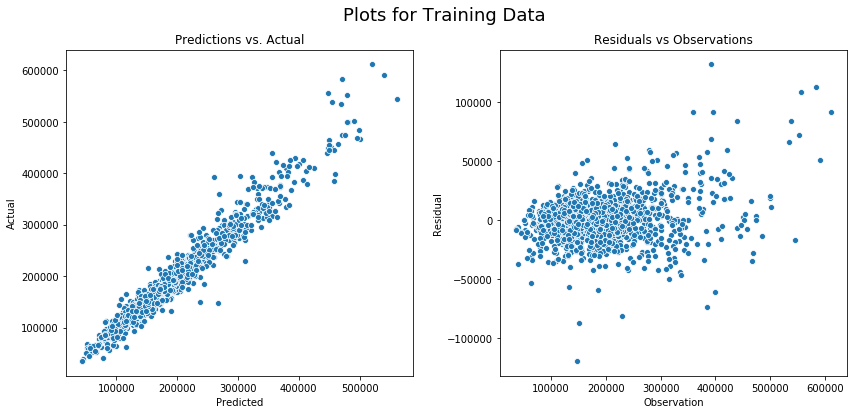

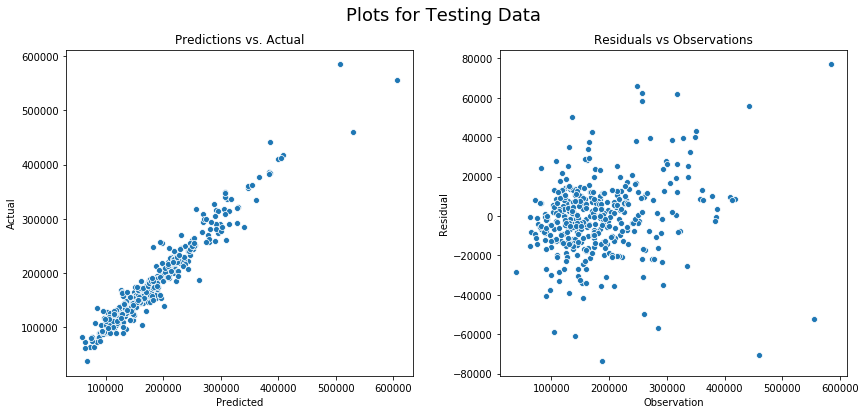

In [100]:
lr, data_w_dum, df_kag = add_dummies_fit_plot('Fireplace Qu', data_ref)

In [101]:
data_ref = data_w_dum

In [102]:
# that may be as good as we can get. Certainly, any more features will likely only be
# very incremental improvements

submission = kaggle_raw[['Id']].copy()
submission['SalePrice'] = np.exp(lr.predict(df_kag))
submission.head()

,Id,SalePrice
0,2658,129444.779760
1,2718,152859.714818
2,2414,215069.244902
3,1989,118761.346750
4,625,169097.813238


In [103]:
submission.to_csv('./submissions/submission_v2_8.csv', index=False)

## 5. Conlclusions:
A reasonable model of the data was generated from approximately 30 of the polynomial expansion features, as well as approximately 10 of the dummy features. The R2 scores for both training and testing data showed excellent parity (~.95 for training and ~0.93 for testing). Cross val scores (K=10) were approximately 0.92 for the training data.